# <center> EE-527: Machine Learning Laboratory </center>
# <center> PROJECT: Topic Modeling with PLSA </center>
*****
### <center> 214161002 - BUDDI KIRAN CHAITANYA </center>
    
*****

libraries

In [ ]:
import numpy as np
import random
import math as M
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd



## utilities & functions block

In [ ]:
# function to normalise a vector v
def normalize(v):
    s = sum(v)
    for i in range(len(v)):
        v[i] = v[i] * 1.0 / s
    return v

# function to calculate the loglikehood value
def llhood(term_doc, p_z, p_w_z, p_d_z):
    V,D = term_doc.shape
    Logl = 0.0
    for w,d in zip(*term_doc.nonzero()):
        p_d_w = np.sum(p_z * p_w_z[w,:] * p_d_z[d,:])
        if p_d_w > 0 : 
            Logl = Logl + (term_doc[w][d] * np.log(p_d_w))
    return Logl

# function to display the top_w words, given the conditional distribution p_w_z, vocab
def dispTopics (top_w, p_w_z, vocab, Z):
  k=np.transpose(np.asarray(p_w_z))
  #topic = []
  topics=[]
  head = ["TOPIC "+str(i+1) for i in range (Z)]
  idx=[]
  for i in range (Z):
    idx.append(np.flip(k[i].argsort()))
  for i in range (top_w):
    row=[]
    for j in range(Z):
      row.append([ vocab[idx[j][i]], round(k[j][idx[j][i]],4) ] )
    topics.append(row)
  #topics.append(topic)
  #print(tabulate(topics, headers=head, tablefmt="pretty", stralign='right'))
  rows=Z//3
  rem=Z%3
  for i in range(rows):
      head=["TOPIC "+str(3*i+j+1) for j in range (3)]
      tops=[[item[3*i], item[3*i+1], item[3*i+2]] for item in topics]
      print(tabulate(tops, headers=head, tablefmt="pretty", stralign='right'))
  head=["TOPIC "+str(3*rows+1+j) for j in range (rem)]
  tops=[[item[3*rows+j] for j in range(rem)] for item in topics]
  print(tabulate(tops, headers=head, tablefmt="pretty", stralign='right'))

# function to display the log-lkelihood trajectory of the EM algorithm
def plot_progress(i_x, l_y, point_c, line_c, corpus):
  fig,ax=plt.subplots(figsize=(14,8))
  ax.plot(i_x,l_y, color = line_c, ls = ':', 
          marker='.', markerfacecolor = point_c,
          markersize = 4)
  plt.grid()
  plt.title ('EM Algo Progress, '+corpus)
  plt.xlabel("EM iteration no")
  plt.ylabel("Log likelihood")
  plt.show()
  

# PLSA class, whose method getTopics will perform PLSA on the term-document matrix
class pLSA :
    def __init__(self):
        pass
    
    def getTopics(self, term_doc, Z, eps, max_iter) : 
        V, D = term_doc.shape

    # placeholder arrays for p(d|z), p(w|z), p(z)
        p_d_z = np.zeros([D, Z], dtype=np.float64) # each row corresponds to a conditional distribution 
                                                   # on topics given doc (pi)
        p_w_z = np.zeros([V, Z], dtype=np.float64) # each col corresponds of a a conditional 
                                                   # distribution on vocab given topic (theta)
        p_z = np.zeros([Z], dtype=np.float64)      # latent topic total probabilities


    # random initialisation & normalisation of the parameters 
        iter = 1
        iter_x = []
        p_d_z = np.random.random([D,Z])
        for d in range(D) :                        
          p_d_z[d] = np.copy(normalize(p_d_z[d]))

        p_w_z = np.random.random([V,Z])           
        for v_idx in range(V) :                    
          p_w_z[v_idx]= np.copy(normalize(p_w_z[v_idx]))

        p_z = np.random.random([Z])
        p_z = np.copy(normalize(p_z))
        l_trajectory = []
        print ("Parameters initialised")
        

        # Iterates until convergance or util max_iterations reached
        
        pp_d_z = p_d_z.copy() # previous iteration values copied
        pp_w_z = p_w_z.copy()
        pp_z = p_z.copy()

        while True :

          p_d_z *= 0.0 # current iteration values reset
          p_w_z *= 0.0
          p_z *= 0.0

          # EM algorithm
          print (f"iter'n no:{iter}, EM-Step progress..", end=" ")
          for w_idx, d_idx in zip(*term_doc.nonzero()):

            # E step :
            p_z_d_w = pp_z * pp_d_z[d_idx,:] * pp_w_z[w_idx, :] # estimating the joint distribution of (d,w)
                                                                # assignment of responsibility for a pair (d,w) to a topic
            p_z_d_w = np.copy(normalize(p_z_d_w)) # normalisation over z
            

            # M step :
            temp = term_doc[w_idx,d_idx] * p_z_d_w
            p_w_z[w_idx, :] += temp # p (w|z)
            p_d_z[d_idx, :] += temp # p (d|z)
            p_z += temp             # p (z)

          p_w_z = np.copy(normalize(p_w_z))
          p_d_z = np.copy(normalize(p_d_z))
          p_z = p_z / term_doc.sum()
          print ("EM Done, finding LogL..", end=" ")

          # likelihood convergence check
          l1 = llhood(term_doc, pp_z, pp_w_z, pp_d_z)
          l2 = llhood(term_doc, p_z, p_w_z, p_d_z)
          l_trajectory.append(l2)
          iter_x.append(iter)
          logLgain = l2 - l1
          print (f"L-Likelihood: {round(l2)}")
          iter+=1
    
          if abs(logLgain) < eps or iter>max_iter:
            print('\nEM ALGO HAS CONVERGED OR END OF ITERATIONS')
            return (l2, l_trajectory, iter_x, p_d_z, p_w_z, p_z)

          pp_d_z = p_d_z.copy()
          pp_w_z = p_w_z.copy()
          pp_z = p_z.copy()



---



## KOS Corpus

#### load the KOS corpus

In [ ]:
term_doc_matrix_kos = np.array([[0 for i in range (6906)] for j in range(3430)])
with open('data/docword.kos.txt') as file:
    for line in file:
        word_data = line.split()
        doc_index=int(word_data[0])-1
        word_index=int(word_data[1])-1
        word_count=int(word_data[2])
        term_doc_matrix_kos [doc_index][word_index] = word_count


#### Run the following cell to start the EM algorithm on KOS corpus; Z (number of topic), max_iter (max iterations) & eps (epsilon) are adjustable hyper-params. 
#### It would take around a minute for each iteration. For 8 topics & 60 iterations the run time has been 25 minutes on Colab
#### for verifying the algorithm/code, choose a higher epsilon & lower iteration (<10) count as it will reduce runtime. 

In [ ]:
eps = 150.0 # threshold for stopping criterion, a hyper parameter
max_iter = 60
pmodel_kos = pLSA()
Z = 8 # number of topics
(l_kos, l_y_kos, i_x_kos, p_d_z_kos, p_w_z_kos, p_z_kos)  = pmodel_kos.getTopics(np.transpose(term_doc_matrix_kos), Z, eps, max_iter)

Parameters initialised
iter'n no:1, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7379407
iter'n no:2, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7375045
iter'n no:3, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7370794
iter'n no:4, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7365783
iter'n no:5, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7358969
iter'n no:6, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7348972
iter'n no:7, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7334514
iter'n no:8, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7315466
iter'n no:9, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7293609
iter'n no:10, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7271895
iter'n no:11, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7253064
iter'n no:12, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -7238274
iter'n no:13, EM-Step prog

#### run the following block to visualise the Log Likelihood values trajectory of EM algo on KOS corpus

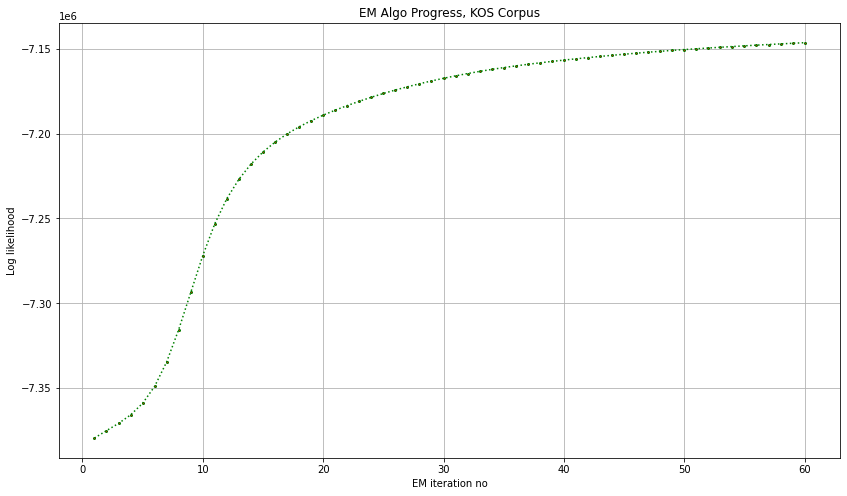

In [ ]:
plot_progress(i_x_kos, l_y_kos, 'red', 'green', 'KOS Corpus')

#### run the following block to display the top-w words from the topics of KOS Corpus (top-w value can be altered)

In [ ]:
vocab_kos = ['' for i in range (6906)]
i=0
with open('data/vocab.kos.txt') as file:
    for line in file:
      vocab_kos[i]=line.replace('\n','')
      i+=1

top_w=15
dispTopics (top_w, p_w_z_kos, vocab_kos, Z)

+-----------------------+-------------------------+-------------------------+
|               TOPIC 1 |                 TOPIC 2 |                 TOPIC 3 |
+-----------------------+-------------------------+-------------------------+
|      ['bush', 0.0614] |       ['party', 0.0199] |    ['november', 0.0645] |
|     ['kerry', 0.0233] |  ['republican', 0.0179] |        ['poll', 0.0132] |
| ['president', 0.0156] |   ['democrats', 0.0153] |        ['house', 0.013] |
|   ['general', 0.0134] | ['republicans', 0.0137] |     ['account', 0.0127] |
|     ['bushs', 0.0108] |       ['state', 0.0135] |   ['electoral', 0.0124] |
|       ['news', 0.009] |  ['democratic', 0.0126] |      ['senate', 0.0122] |
|       ['oct', 0.0073] |       ['senate', 0.012] | ['republicans', 0.0122] |
|  ['election', 0.0064] |         ['gop', 0.0097] |    ['governor', 0.0121] |
|    ['voters', 0.0061] |    ['election', 0.0085] |       ['polls', 0.0117] |
|    ['george', 0.0061] |      ['states', 0.0085] |          ['v



---



## NIPS Corpus

#### load the NIPS corpus

In [ ]:
term_doc_matrix_nips = np.array([[0 for i in range (12419)] for j in range(1500)])
with open('data/docword.nips.txt') as file:
    for line in file:
        word_data = line.split()
        doc_index=int(word_data[0])-1
        word_index=int(word_data[1])-1
        word_count=int(word_data[2])
        term_doc_matrix_nips [doc_index][word_index] = word_count


#### Run the following cell to start the EM algorithm on NIPS corpus; Z (number of topic), max_iter (max iterations) & eps (epsilon) are adjustable hyper-params. 
#### It would take around a minute for each iteration. For 10 topics & 70 iterations the run time has been 35 minutes on Colab
#### for verifying the algorithm/code, choose a higher epsilon & lower iteration (<10) count as it will reduce runtime. 

In [ ]:
eps = 200.0 # threshold for stopping criterion
max_iter = 70
pmodel_nips = pLSA()
Z = 10 # number of topics
(l_nips, l_y_nips, i_x_nips, p_d_z_nips, p_w_z_nips, p_z_nips)  = pmodel_nips.getTopics(np.transpose(term_doc_matrix_nips), Z, eps, max_iter)

Parameters initialised
iter'n no:1, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29240706
iter'n no:2, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29222569
iter'n no:3, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29205233
iter'n no:4, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29185769
iter'n no:5, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29161873
iter'n no:6, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29131323
iter'n no:7, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29092301
iter'n no:8, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -29044627
iter'n no:9, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -28991021
iter'n no:10, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -28936466
iter'n no:11, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -28885637
iter'n no:12, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -28841095
iter'n no:13, 

#### run the following block to visualise the Log Likelihood trajectory of EM algo on NIPS corpus

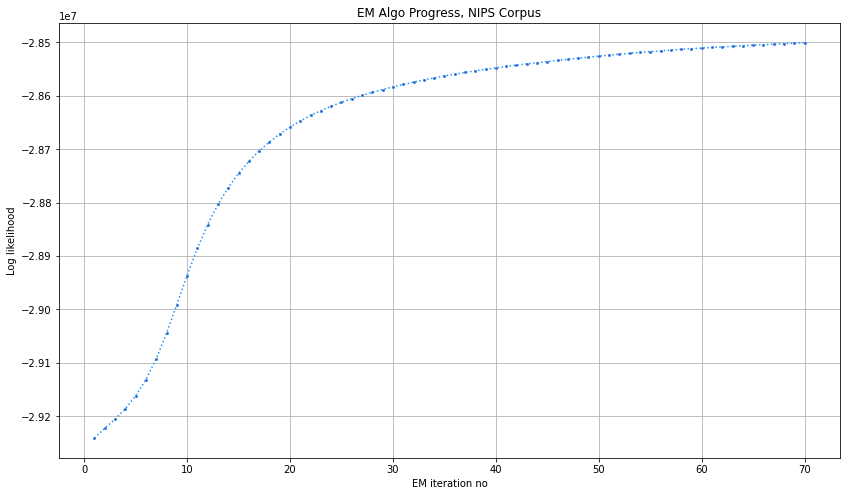

In [ ]:
plot_progress(i_x_nips, l_y_nips, 'red', 'dodgerblue', 'NIPS Corpus')

#### run the following block to display the top-w words from the topics of NIPS Corpus (top-w value can be altered)

In [ ]:
vocab_nips = ['' for i in range (12419)]
i=0
with open('data/vocab.nips.txt') as file:
    for line in file:
      vocab_nips[i]=line.replace('\n','')
      i+=1
top_w=12
dispTopics (top_w, p_w_z_nips, vocab_nips, Z)

+----------------------+--------------------------+---------------------------+
|              TOPIC 1 |                  TOPIC 2 |                   TOPIC 3 |
+----------------------+--------------------------+---------------------------+
|  ['network', 0.0428] |        ['model', 0.0354] |      ['learning', 0.0172] |
|   ['neural', 0.0188] |         ['data', 0.0228] |     ['algorithm', 0.0116] |
|    ['input', 0.0166] |    ['parameter', 0.0129] |        ['action', 0.0103] |
|    ['system', 0.013] | ['distribution', 0.0112] |      ['function', 0.0098] |
|   ['output', 0.0125] |      ['gaussian', 0.011] |       ['problem', 0.0091] |
| ['training', 0.0095] |    ['algorithm', 0.0103] |        ['policy', 0.0067] |
|    ['layer', 0.0086] |  ['probability', 0.0076] |          ['step', 0.0066] |
|      ['set', 0.0086] |   ['likelihood', 0.0073] |         ['model', 0.0062] |
|  ['pattern', 0.0075] |       ['method', 0.0072] |        ['method', 0.0061] |
|      ['net', 0.0074] |           ['set



---



## NYT CORPUS

#### load the NYT Corpus

In [ ]:
with open('data/nyt_data.txt') as f:
  docs = f.readlines()
docs = [x.strip().strip('\n').strip("'") for x in docs] 

D = 8447
V = 3012 
term_doc_matrix_nyt = np.array([[0 for i in range (D)] for j in range(V)])

for col in range(len(docs)):
    for row in docs[col].split(','):
        term_doc_matrix_nyt[int(row.split(':')[0])-1,col] = int(row.split(':')[1])

#### Run the following cell to start the EM algorithm on NYT corpus; Z (number of topic), max_iter (max iterations) & eps (epsilon) are adjustable hyper-params. 
#### It would take around a minute for each iteration. For 16 topics & 50 iterations the run time has been 40 minutes on Colab
#### for verifying the algorithm/code, choose a higher epsilon & lower iteration (<10) count as it will reduce runtime. 

In [43]:
eps = 100.0 # threshold for stopping criterion
max_iter = 50
pmodel_nyt = pLSA()
Z = 16 # number of topics
(l_nyt, l_y_nyt, i_x_nyt, p_d_z_nyt, p_w_z_nyt, p_z_nyt)  = pmodel_nyt.getTopics(term_doc_matrix_nyt, Z, eps, max_iter)

Parameters initialised
iter'n no:1, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -20005399
iter'n no:2, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -20000769
iter'n no:3, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19996182
iter'n no:4, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19991203
iter'n no:5, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19985306
iter'n no:6, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19977754
iter'n no:7, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19967497
iter'n no:8, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19953138
iter'n no:9, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19933122
iter'n no:10, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19906372
iter'n no:11, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19873368
iter'n no:12, EM-Step progress.. EM Done, finding LogL.. L-Likelihood: -19836664
iter'n no:13, 

#### run the following block to visualise the Log Likelihood trajectory of EM algo on NYT corpus

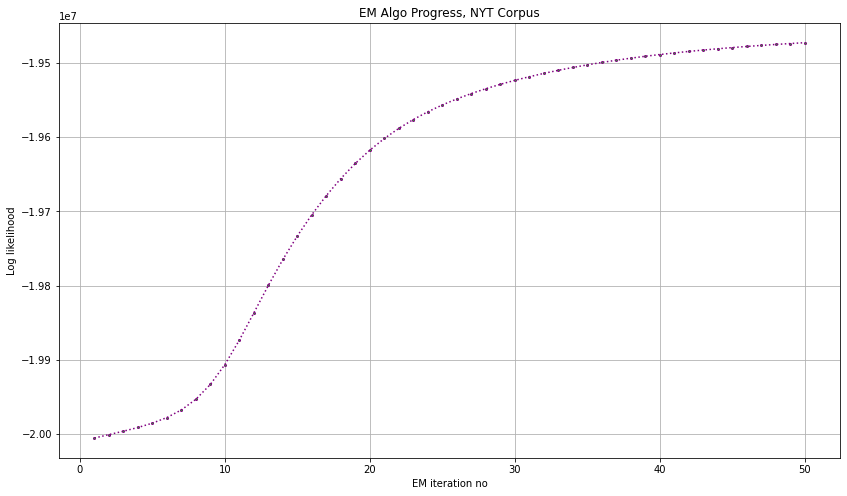

In [48]:
plot_progress(i_x_nyt, l_y_nyt, 'lime', 'purple', 'NYT Corpus')

#### run the following block to display the top-w words from the topics of NYT Corpus (top-w value can be altered)

In [49]:
# contains vocabs with rows as index
with open('data/nyt_vocab.dat') as f:
    vocab_nyt = f.readlines()
vocab_nyt = [x.strip().strip('\n').strip("'") for x in vocab_nyt] 

top_w=10
dispTopics (top_w, p_w_z_nyt, vocab_nyt, Z)


+-----------------------+------------------------+----------------------+
|               TOPIC 1 |                TOPIC 2 |              TOPIC 3 |
+-----------------------+------------------------+----------------------+
|   ['official', 0.027] |   ['campaign', 0.0168] |   ['police', 0.0139] |
| ['yesterday', 0.0189] |       ['vote', 0.0162] |     ['city', 0.0135] |
|   ['comment', 0.0155] |  ['political', 0.0148] |   ['street', 0.0123] |
|    ['report', 0.0151] | ['republican', 0.0121] | ['building', 0.0121] |
|      ['news', 0.0135] |   ['candidate', 0.012] |    ['house', 0.0104] |
|    ['office', 0.0125] |   ['election', 0.0113] |      ['man', 0.0102] |
|      ['tell', 0.0117] |      ['party', 0.0113] |     ['kill', 0.0096] |
| ['spokesman', 0.0115] |     ['leader', 0.0096] |     ['home', 0.0085] |
|   ['request', 0.0107] | ['democratic', 0.0093] |     ['live', 0.0084] |
|     ['meeting', 0.01] |      ['state', 0.0092] | ['resident', 0.0081] |
+-----------------------+-------------

*****
*****
-----------------------------------------------END OF PROJECT---------------------